Notebook to slice maxar images like drones, and to generate training samples as pairs maxar-planet

In [1]:
import os
import shutil
import json
import subprocess
import warnings

from tqdm import tqdm
import numpy as np
import pandas as pd
import rasterio
import rasterio.mask
from shapely.geometry import box, mapping, shape
from rasterio.plot import reshape_as_image, reshape_as_raster
from rasterio.features import shapes
import geopandas as gpd
import cv2
from skimage import exposure

import os
from dataclasses import dataclass
import shutil
import re

from tqdm import tqdm
import numpy as np
import geopandas as gpd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import rasterio
from rasterio.windows import Window
from rasterio.enums import Resampling
from rasterio import features as rasterio_features
from affine import Affine
from rasterio.plot import reshape_as_image, reshape_as_raster
from shapely.geometry import box
from rasterio.features import geometry_mask
from shapely.geometry import Polygon, MultiPolygon, shape
import rasterio.mask
from rasterio.enums import Resampling


# V1 (may 2023, do not use)

In [2]:
maxar_images_root = '/home/quantum/Projects/VisNavigate/data/test_pipe/test_sp/MAXAR/maxar_images'

maxar_aoi_root = '/home/quantum/Projects/VisNavigate/data/test_pipe/test_sp/MAXAR/aoi'
basemap_dir = '/home/quantum/Projects/VisNavigate/data/test_pipe/test_sp/MAXAR/Planet_basemap'

maxar_drones_dir = '/home/quantum/Projects/VisNavigate/data/test_pipe/test_sp/MAXAR/maxar_tiles'

train_data_root = '/home/quantum/Projects/VisNavigate/data/test_pipe/test_sp/MAXAR/train'




maxar_images_root = '/home/quantum/Projects/VisNavigate/data/test_pipe/test_sp/OAM/images'

maxar_aoi_root = '/home/quantum/Projects/VisNavigate/data/test_pipe/test_sp/OAM/aoi'
basemap_dir = '/home/quantum/Projects/VisNavigate/data/test_pipe/test_sp/OAM/Planet_basemap'

maxar_drones_dir = '/home/quantum/Projects/VisNavigate/data/test_pipe/test_sp/OAM/maxar_tiles'

train_data_root = '/home/quantum/Projects/VisNavigate/data/test_pipe/test_sp/OAM/train'


In [204]:
shutil.rmtree(maxar_aoi_root, ignore_errors=True)
os.mkdir(maxar_aoi_root)

shutil.rmtree(basemap_dir, ignore_errors=True)
os.mkdir(basemap_dir)

shutil.rmtree(maxar_drones_dir, ignore_errors=True)
os.mkdir(maxar_drones_dir)

shutil.rmtree(train_data_root, ignore_errors=True)
os.mkdir(train_data_root)


In [3]:
maxar_df = pd.read_json(os.path.join(maxar_images_root, 'meta.json'), orient='records', dtype={'month': str, 'year': str, 'image_id': str})
maxar_df['name'] = maxar_df['image_id'] + '-visual.tif'
maxar_df.head()


,month,year,image_id,name
0,02,2022,0092_oam_2022-02-01_image,0092_oam_2022-02-01_image-visual.tif


## Step 0: Downscale big images: 

In [4]:
def downscale_image_to_shape(path_to_image, maximum_image_size, *, resolution_target_treshold: float = 1.) -> str:
    """
    Checks size of tif image in pixels. If it is more than maximum_image_size,
    downscales to this size. Returns original path if image should be downscaled.
    If not, return original shape

    Args:
        path_to_image (str): path to image. Must end on '-visual.tif'
        maximum_image_size (int): maximum allowed image size
        resolution_target_treshold (float) resolution threshold of the resulting image, in meters per pixel.
            If the resolution the result of the downscale is worse than this threshold, raise the warning.

    Returns:
        str: path_to_image if image size < maximum_image_size otherwise path to dawnsampled
    """

    with rasterio.open(path_to_image) as dataset:
        meta = dataset.meta
        if meta['width'] < maximum_image_size and meta['height'] < maximum_image_size:
            return path_to_image
        original_resolution = dataset.res[0]

        exceeding_size_ratios = meta['width']/maximum_image_size, meta['height']/maximum_image_size
        upscale_factor = 1 / max(exceeding_size_ratios)

        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * upscale_factor),
                int(dataset.width * upscale_factor)
            ),
            resampling=Resampling.nearest
        )
        transform = dataset.transform * dataset.transform.scale(
            (dataset.width / data.shape[-1]),
            (dataset.height / data.shape[-2])
        )

        meta.update({
                "transform": transform,
                'width': data.shape[2],
                'height': data.shape[1]
                    })

    downscale_path = path_to_image.replace('-visual.tif', '-downscale-visual.tif')
    with rasterio.open(downscale_path, "w", **meta) as dest:
        dest.write(data)
    with rasterio.open(downscale_path, "r", **meta) as src:
        new_resolution = src.res[0]
        if new_resolution > resolution_target_treshold:
            warnings.warn(f'After downscale, resolution changed from {original_resolution:.2f} to {new_resolution:.2f} meters per pixel. Threshold is {resolution_target_treshold:.2f}')
    return downscale_path


In [5]:
downscale_names = []
for _, row in maxar_df.iterrows():
    maxar_path = os.path.join(maxar_images_root, row['name'])
    new_path = downscale_image_to_shape(maxar_path, 1_000)
    new_name = os.path.basename(new_path)
    downscale_names.append(new_name)

maxar_df['name'] = downscale_names


/tmp/ipykernel_36432/4165166432.py:51: UserWarning: After downscale, resolution changed from 0.33 to 1.30 meters per pixel. Threshold is 1.00
  warnings.warn(f'After downscale, resolution changed from {original_resolution:.2f} to {new_resolution:.2f} meters per pixel. Threshold is {resolution_target_treshold:.2f}')


In [6]:
maxar_df.head()


,month,year,image_id,name
0,02,2022,0092_oam_2022-02-01_image,0092_oam_2022-02-01_image-downscale-visual.tif


## Step 1: Load planet basemap for maxar

repo for downloadingPlanet basemaps: https://github.com/QuantuMobileSoftware/planet_basemap_downloader

Create AOI from maxar rasters

In [7]:
def save_image_polygon(im_path, save_path):
    with rasterio.open(im_path) as src:
        bounds = src.bounds
        bbox = box(bounds.left, bounds.bottom, bounds.right, bounds.top)
        gdf = gpd.GeoDataFrame(geometry=[bbox], crs=src.crs)
        gdf.to_file(save_path, driver='GeoJSON')


In [8]:
for _, row in maxar_df.iterrows():
    maxar_path = os.path.join(maxar_images_root, row['name'])
    maxar_aoi_path = os.path.join(maxar_aoi_root, row['image_id'] + '-aoi.geojson')
    save_image_polygon(maxar_path, maxar_aoi_path)


/home/quantum/Projects/VisNavigate/.vn_env/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


run planet_basemap_downloader

In [211]:
def get_cl_command(maxar_aoi_path, basemap_path, year, month):
    cmd = f'/home/quantum/Projects/VisNavigate/.vn_env/bin/python /home/quantum/Projects/VisNavigate/planet_basemap_downloader/main.py --api_key PLAK8b275ed2feab4db49e90ca77af81c060 --geojson_path {maxar_aoi_path} --save_dir {basemap_path} --year {year} --month {month}'
    cmd = cmd.split()
    subprocess.run(cmd)


for _, row in maxar_df.iterrows():
    maxar_aoi_path = os.path.join(maxar_aoi_root, row['image_id'] + '-aoi.geojson')
    basemap_path = os.path.join(basemap_dir, row['image_id'])
    cl = get_cl_command(maxar_aoi_path, basemap_path, row['year'], row['month'])


100%|██████████| 6/6 [00:00<00:00, 181.99it/s]


## Step 2: slice maxar

In [9]:
def get_image_polygon_df(im_path, buffer_mult=1):
    with rasterio.open(im_path) as src:
        bbox = box(*src.bounds)
        if buffer_mult > 1:
            bbox_size = np.sqrt(bbox.area)
            bbox = bbox.buffer((buffer_mult-1)*bbox_size, cap_style=2)
        gdf = gpd.GeoDataFrame(geometry=[bbox], crs=src.crs)
        return gdf

def get_raster_crs(raster_path):
    with rasterio.open(raster_path) as src:
        return src.crs


def crop_raster(polygon, src_path, dst_path, *, to_rgb=False, nodata_treshold=0.0):
    """
    Crop a Sentinel 2 raster using a Shapely Polygon object.

    Args:
        polygon (shapely.geometry.Polygon): The polygon object used for cropping.
        src_path (str): The path to the source raster file.
        dst_path (str): The path to the destination cropped raster file.
        nodata_treshold (float): If fraction of no data values is more then treshold, do not write raster

    Returns:
        None
    """
    with rasterio.open(src_path) as src:

        out_image, out_transform = rasterio.mask.mask(src, [polygon], crop=True, nodata=0)

        if to_rgb:
            out_image = reshape_as_image(out_image)
            out_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)
            out_image = reshape_as_raster(out_image)

        if out_image.shape[0] == 1:
            out_image = reshape_as_image(out_image).squeeze()
            out_image = cv2.cvtColor(out_image, cv2.COLOR_GRAY2RGB)
            out_image = reshape_as_raster(out_image)

        out_image = out_image[:3, :, :]

        out_meta = src.meta
        out_meta.update({"driver": "GTiff",
                "count": out_image.shape[0],
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform,
                'nodata': 0})

        nodata_ratio_in_crop = np.mean(np.max(out_image, axis=0)==0)
        if nodata_ratio_in_crop > nodata_treshold:
            return

        with rasterio.open(dst_path, "w", **out_meta) as dest:
            dest.write(out_image)


In [10]:
from typing import List
from shapely.geometry import Polygon
from random import uniform
import math

def get_bounds_vector(min_coord, max_coord, min_len, max_len):
    row_start = row_end = min_coord
    rows_bounds = []
    while row_end < max_coord:
        row_start = row_end
        row_end = row_start + np.random.randint(min_len, max_len)
        rows_bounds.append((row_start, row_end))
    return rows_bounds


def make_mosaic(polygon: Polygon, min_size: float=200, max_size: float=1000) -> List[Polygon]:
    """
    Generates random rectangular polygons within the given polygon, with sizes ranging from min_size to max_size in meters.

    Args:
        polygon (Polygon): The input polygon in which to generate rectangular mosaics.
        min_size (float, optional): The minimum size (in meters) of the mosaics. Defaults to 200.
        max_size (float, optional): The maximum size (in meters) of the mosaics. Defaults to 1000.

    Returns:
        List[Polygon]: A list of generated mosaics as Shapely Polygon objects.
    """
    min_size = max(min_size, 0)
    max_size = max(max_size, min_size)

    minx, miny, maxx, maxy = polygon.bounds

    rows_bounds = get_bounds_vector(miny, maxy, min_size, max_size)

    tiles = []
    metadata = []
    for row_bound in rows_bounds:
        H = row_bound[1] - row_bound[0]
        min_col_size = max(min_size, int(0.5*H))
        max_col_size = max(max_size, int(1.5*H))
        col_bounds = get_bounds_vector(minx, maxx, min_col_size, max_col_size)
        for col_bound in col_bounds:
            x1, x2 = col_bound
            y1, y2 = row_bound
            tile = Polygon([(x1, y1), (x1, y2), (x2, y2), (x2, y1), (x1, y1)])

            if tile.within(polygon) or tile.intersects(polygon):
                tiles.append(tile)
                metadata.append({'x0': x1, 'x1': x2, 'y0': y1, 'y1': y2})
    tiles_df = gpd.GeoDataFrame(metadata, geometry=tiles)
    return tiles_df

def slice_tif_on_tiles(tif_path, tiles_dest_dir, min_size: float=200, max_size: float=1000, to_rgb=False, nodata_treshold=0.0):
    poly_df = get_image_polygon_df(tif_path)
    raster_crs = get_raster_crs(tif_path)
    poly_df.to_crs(raster_crs, inplace=True)
    poly = poly_df['geometry'].iloc[0]

    tiles_df = make_mosaic(poly, min_size, max_size)
    tiles_df.set_crs(raster_crs)

    # for tile_id, tile_meta in tqdm(tiles_df.iterrows(), total=len(tiles_df)):
    for tile_id, tile_meta in (pbar:=tqdm(tiles_df.iterrows(), total=len(tiles_df))):
        tile_name = f"tile_{tile_id}.tif"
        tile_path = os.path.join(tiles_dest_dir, tile_name)
        crop_raster(tile_meta['geometry'], tif_path, tile_path, to_rgb=to_rgb, nodata_treshold=nodata_treshold)
        pbar.set_postfix_str(f"Really saved {len(os.listdir(tiles_dest_dir))}, the rest are ignored because there is a lot of empty space")


In [11]:
shutil.rmtree(maxar_drones_dir, ignore_errors=True)
os.mkdir(maxar_drones_dir)


In [12]:
for _, row in maxar_df.iterrows():
    maxar_path = os.path.join(maxar_images_root, row['name'])
    drones_subfolder = os.path.join(maxar_drones_dir, row['image_id'])

    shutil.rmtree(drones_subfolder, ignore_errors=True)
    os.mkdir(drones_subfolder)

    slice_tif_on_tiles(maxar_path, drones_subfolder, 750, 850, to_rgb=False, nodata_treshold=0.4)


100%|██████████| 4/4 [00:00<00:00, 57.12it/s, Really saved 2, the rest are ignored because there is a lot of empty space]


## Step 3: Create training pairs

Creating train pairs as:
- [satellite id]-[tile id]_UAV.tif - drone image
- [satellite id]-[tile id].tif - satellite image

For PlanetScope basemap, satellite id is the name as maxar raster

In [13]:
def pad_raster(src_path, dst_path, desired_coverage=(720,960), min_pad_ratio=1.2, nodata_treshold=0.0):
    """
    Pad raster by coverage in meters.

    Args:
        src_path (str): The path to the source raster file.
        dst_path (str): The path to the destination of padded raster file.
        desired_coverage (Tuple[float]): size in meters of output raster
        min_pad_ratio (float): minimal (out size)/(input size).
            If padding size ratio estimated from desired_coverage is less then min_pad_ratio,
            min_pad_ratio will be used.
        nodata_treshold (float): If fraction of no data values is more then treshold, do not write raster

    """
    with rasterio.open(src_path) as src:
        bounds = src.bounds

        center_x = (bounds.left + bounds.right) / 2
        center_y = (bounds.bottom + bounds.top) / 2

        cover_now = (int(bounds.right - bounds.left), int(bounds.top - bounds.bottom))

        if cover_now[0] < cover_now[1]:
            desired_coverage = (min(desired_coverage), max(desired_coverage))
        else:
            desired_coverage = (max(desired_coverage), min(desired_coverage))

        pad_size = max(desired_coverage[0]/cover_now[0], desired_coverage[1]/cover_now[1], min_pad_ratio)
        scale_x, scale_y = pad_size, pad_size

        out_image = src.read()
        out_meta = src.meta
        out_transform = src.transform

        left_top_x, left_top_y = bounds.left, bounds.top
        lt_delta_x, lt_delta_y = center_x - left_top_x, center_y - left_top_y
        pad_offset_x,pad_offset_y  = lt_delta_x * (scale_x-1),  lt_delta_y * (scale_y-1)

        result_affine  = Affine.translation(-pad_offset_x, -pad_offset_y)
        out_transform = result_affine * out_transform


        pad1 = int((int(src.width * scale_x) - src.width)/2)
        pad2 = int((int(src.height * scale_y) - src.height)/2)
        out_image = np.pad(out_image, ((0, 0), (pad2, pad2), (pad1, pad1)), 'constant', constant_values=0)
        # out_image = np.pad(out_image, ((0, 0), (pad1, pad1), (pad2, pad2)), 'constant', constant_values=0)


        out_meta.update({"driver": "GTiff",
                "transform": out_transform,
                'width': out_image.shape[2],
                'height': out_image.shape[1],
                'nodata': 0
                 })


        nodata_ratio_in_crop = np.mean(np.max(out_image, axis=0)==0)
        if nodata_ratio_in_crop > nodata_treshold:
            print(nodata_ratio_in_crop)
            return None

        with rasterio.open(dst_path, "w", **out_meta) as dest:
            dest.write(out_image)

        with rasterio.open(dst_path) as src:
            bounds = src.bounds
            actual_coverage = (bounds.right-bounds.left, bounds.top-bounds.bottom)
        return actual_coverage


In [14]:
shutil.rmtree(train_data_root, ignore_errors=True)
os.mkdir(train_data_root)


In [15]:
for _, row in maxar_df.iterrows():
    # get path to subfolder where tiles are stored, and names of those tiles
    drones_subfolder = os.path.join(maxar_drones_dir, row['image_id'])
    drones_images_names = os.listdir(drones_subfolder)

    # path where we saved basemap tif in step 1
    basemap_path = os.path.join(basemap_dir, row['image_id'], row['image_id']+'-aoi.tif')

    # iterate over maxar crops (like they are drone images)
    for drone_img_name in tqdm(drones_images_names, desc=f"Processing {row['image_id']}"):
        drone_photo_path = os.path.join(drones_subfolder, drone_img_name)

        # create path where to store padded drone image
        # Example: tile "tile_22.tif", image_id "103001003C3E4500", sample name "103001003C3E4500-tile-22_UAV.tif"
        drone_suffix = drone_img_name.replace('.tif', '').replace('_', '-')
        drone_padded_photo_name = f"{row['image_id']}-{drone_suffix}_UAV.tif"
        drone_padded_photo_path = os.path.join(train_data_root, drone_padded_photo_name)

        # desired coverage in meters. We want to get ~ 240 by 320 pixels in the basemap crop.
        # The basemap has a resolution of 3.8. Therefore, coverage is 240*3.8, 320*3.8.
        desired_coverage = (912, 1216)

        padded_coverage = pad_raster(drone_photo_path, drone_padded_photo_path, desired_coverage, min_pad_ratio=1.01, nodata_treshold=0.7)
        if padded_coverage is None: # big nodata
            continue

        # we read padded drone image to crop satellite to the same aoi
        padded_image_bounds = get_image_polygon_df(drone_padded_photo_path)
        sat_crs = get_raster_crs(basemap_path)
        padded_image_bounds.to_crs(sat_crs, inplace=True)
        padded_image_bounds = padded_image_bounds['geometry'].iloc[0]

        # cropped satellite name should be the same as corresponding UAV image, But without _UAV suffix
        sat_cropped_photo_path = drone_padded_photo_path.replace('_UAV.tif', '.tif')
        crop_raster(padded_image_bounds, basemap_path, sat_cropped_photo_path, nodata_treshold=1)


Processing 0092_oam_2022-02-01_image: 100%|██████████| 2/2 [00:00<00:00, 27.98it/s]

0.92770281350294


## plot single

In [16]:
with rasterio.open(drone_padded_photo_path) as src:
    drone_image = reshape_as_image( src.read())

with rasterio.open(sat_cropped_photo_path) as src:
    sat_image = reshape_as_image( src.read())

drone_image = cv2.imread(drone_padded_photo_path)
sat_image = cv2.imread(sat_cropped_photo_path)
drone_image.shape, sat_image.shape


((697, 984, 3), (283, 396, 3))

In [17]:
with rasterio.open(sat_cropped_photo_path, 'r') as src:
    print(src.transform)

with rasterio.open(drone_photo_path, 'r') as src:
    print(src.transform)


| 0.00, 0.00, 28.82|
| 0.00,-0.00, 47.04|
| 0.00, 0.00, 1.00|
| 1.30, 0.00, 232033.95|
| 0.00,-1.31, 211327.20|
| 0.00, 0.00, 1.00|


In [18]:
drone_image = cv2.resize(drone_image, sat_image.shape[:2][::-1])

drone_image.shape


(283, 396, 3)

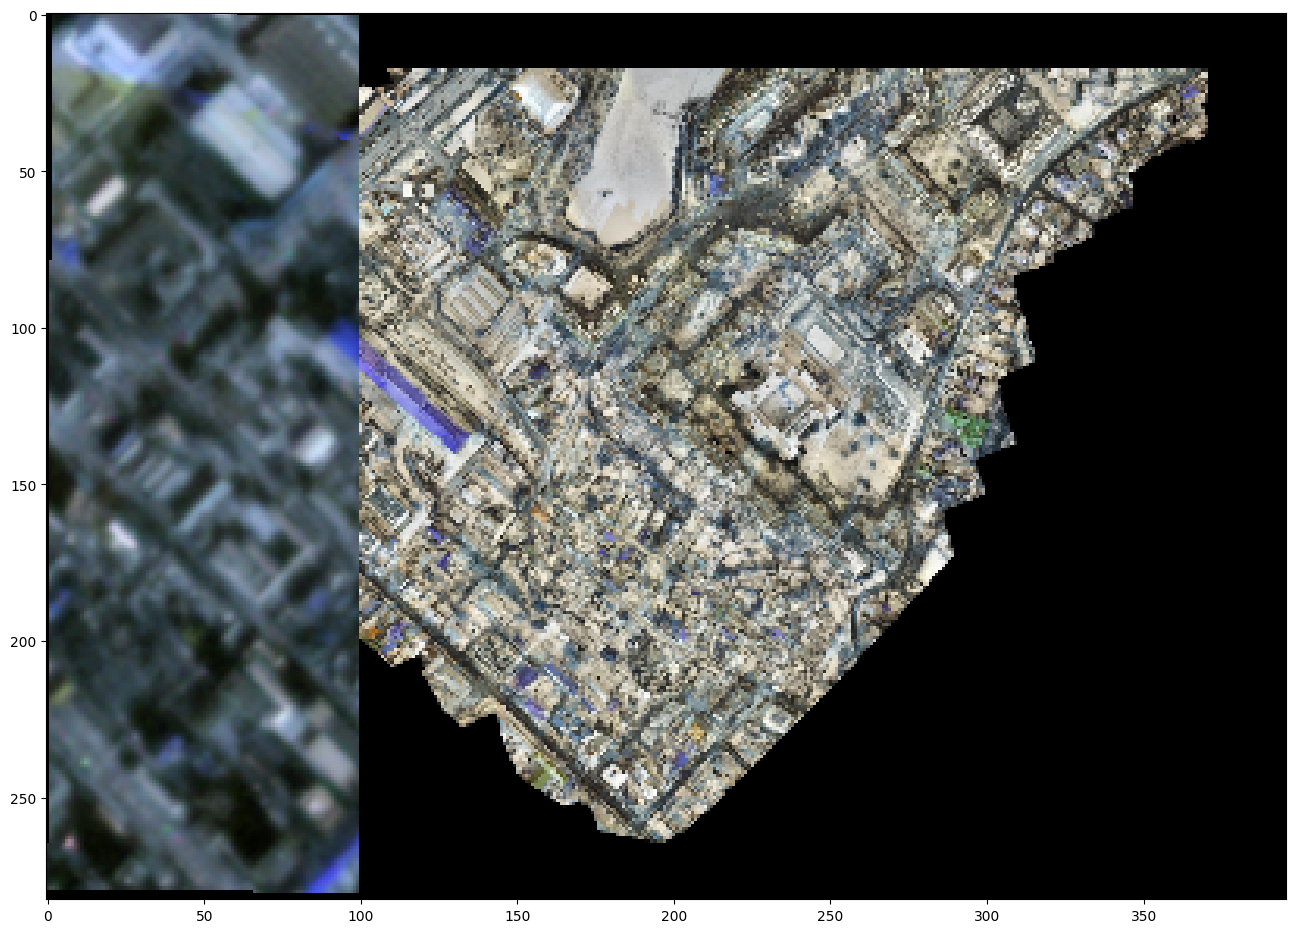

In [23]:
plt.figure(figsize=(16,16))

comb = drone_image.copy()
slice_x = 100
comb[:, :slice_x, :] = sat_image[:, :slice_x, :]
plt.imshow(comb)


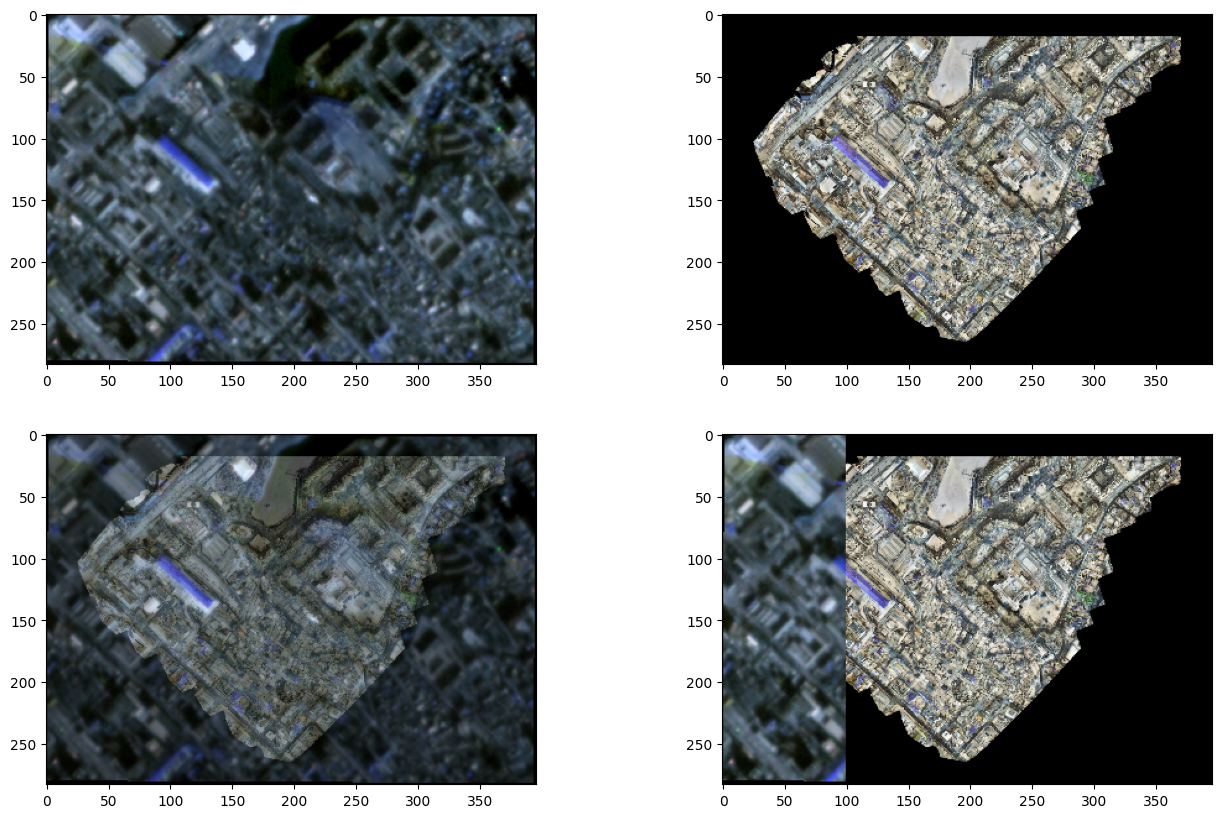

In [24]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
axs = axs.flatten()
axs[0].imshow(sat_image)
axs[1].imshow(drone_image)


axs[2].imshow(sat_image)
axs[2].imshow(drone_image, alpha=0.4)

comb = drone_image.copy()
comb[:, :slice_x, :] = sat_image[:, :slice_x, :]
axs[3].imshow(comb)


# V2

In [58]:
maxar_root = "/home/quantum/Projects/VisNavigate/data/Satellite/Maxar"

maxar_raws_path = os.path.join(maxar_root, 'all_raw')


### save filtered names

In [72]:
import os

maxar_preview_path = os.path.join(maxar_root, 'preview')

filenames = os.listdir(maxar_preview_path)

txt_file_path =maxar_preview_path + '.txt'
with open(txt_file_path, "w") as txt_file:
    for filename in filenames:
        txt_file.write(filename + "\n")


### download basemaps

In [59]:
def get_raster_aoi(tif_file):
    with rasterio.open(tif_file) as src:
        crs = src.crs
        bounds = src.bounds

    polygon = Polygon([
        (bounds.left, bounds.bottom),
        (bounds.right, bounds.bottom),
        (bounds.right, bounds.top),
        (bounds.left, bounds.top)
    ])

    gdf = gpd.GeoDataFrame({'geometry': [polygon]}, crs=crs)
    return gdf


In [ ]:
import cv2


In [60]:
import mercantile
import geopandas as gpd
import os
import urllib.request
from urllib.error import HTTPError
import shutil

import time
from tqdm import tqdm
import cv2
import rasterio
import numpy as np
from rasterio import Affine
from shapely.geometry import Point, Polygon
import math
import argparse
RESOLUTION = 3.1
TILE_SIZE = 256


def convert_wgs_to_utm(lon, lat):
    utm_band = '{:02d}'.format(math.floor((lon + 180) / 6) % 60 + 1)
    crs = 'epsg:326' + utm_band if lat >= 0 else 'epsg:327' + utm_band
    return crs


def get_lon_lat(xtile, ytile, zoom):
    Z2 = math.pow(2, zoom)
    lon_deg = xtile / Z2 * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / Z2)))
    lat_deg = math.degrees(lat_rad)
    return lon_deg, lat_deg


def convert_point(x, y, crs):
    lon, lat = get_lon_lat(x, y, 15)
    point = gpd.GeoDataFrame(geometry=[Point((lon, lat))])
    point = point.set_crs(epsg='4326')
    # point = point.to_crs(epsg=crs.split(":")[1])
    return point


class TileDownloader:
    def __init__(self, api_key, month, year, save_dir, tiles_dir=None):
        self.api_key = api_key
        self.tile_size = TILE_SIZE
        self.resolution = RESOLUTION
        self.year = str(year)
        month = str(month).zfill(2)
        self.month = month
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

        if tiles_dir is None:
            tiles_dir = os.path.join(self.save_dir, 'tiles')
        self.tiles_dir = tiles_dir
        os.makedirs(self.tiles_dir, exist_ok=True)
        self.result_tif_path = os.path.join(save_dir, os.path.basename(save_dir)+'.tif')

    def download_tile(self, tile):
        x = tile.x
        y = tile.y
        z = tile.z
        link = f"https://tiles0.planet.com/basemaps/v1/planet-tiles/global_monthly_{self.year}_{self.month}_mosaic/gmap/{z}/{x}/{y}.png?api_key={self.api_key}"
        save_path = os.path.join(self.tiles_dir, f"{x}_{y}_{z}.png")
        urllib.request.urlretrieve(link, save_path)

    def get_tiles(self, polys):
        # polys = gpd.read_file(polygon_path)
        polys.to_crs('EPSG:4326', inplace=True)
        minx, miny, maxx, maxy = polys['geometry'].values[0].bounds

        tiles = mercantile.tiles(minx, miny, maxx, maxy, [15], truncate=False)
        # for tile in tqdm(mercantile.tiles(minx, miny, maxx, maxy, [15], truncate=False), total=len(list(tiles))):
        for tile in mercantile.tiles(minx, miny, maxx, maxy, [15], truncate=False):
            self.download_tile(tile)
            time.sleep(1)

    def collect_tif(self, polys):
        # polys = gpd.read_file(polygon_path)
        polys.to_crs('EPSG:4326', inplace=True)

        minx, miny, maxx, maxy = polys['geometry'].values[0].bounds
        tiles = mercantile.tiles(minx, miny, maxx, maxy, [15], truncate=False)
        tiles_np = np.array(list(tiles))
        width_num = tiles_np[:, 0].max() - tiles_np[:, 0].min()
        height_num = tiles_np[:, 1].max() - tiles_np[:, 1].min()
        width = width_num * TILE_SIZE + TILE_SIZE
        height = height_num * TILE_SIZE + TILE_SIZE
        crs = convert_wgs_to_utm(minx, maxy)

        top_left = convert_point(tiles_np[0, 0], tiles_np[0, 1], crs)
        bottom_right = convert_point(tiles_np[-1, 0] + 1, tiles_np[-1, 1] + 1, crs)

        raster_img = np.zeros((height, width, 3), dtype=np.uint8)
        for tile in (mercantile.tiles(minx, miny, maxx, maxy, [15], truncate=False)):
            x = tile.x
            y = tile.y
            z = tile.z
            x_img = (x-tiles_np[:, 0].min()) * TILE_SIZE
            y_img = (y-tiles_np[:, 1].min()) * TILE_SIZE
            img_path = os.path.join(self.tiles_dir, f"{x}_{y}_{z}.png")
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            try:
                raster_img[y_img:y_img+TILE_SIZE, x_img:x_img+TILE_SIZE, :] = img
            except:
                print(y_img, x_img)
                continue

        tl_point = top_left['geometry'].values[0].coords[0]
        br_point = bottom_right['geometry'].values[0].coords[0]

        transform = rasterio.transform.from_bounds(tl_point[0], br_point[1], br_point[0], tl_point[1], width, height)
        meta = {'height': height,
                'width': width,
                'transform': transform,
                'driver': "Gtiff",
                'count': 3,
                'dtype': 'uint8',
                'crs': top_left.crs}

        raster_path = os.path.join(self.result_tif_path)
        with rasterio.open(raster_path, "w", **meta) as dst:
            for band in range(3):
                dst.write(raster_img[:, :, band], band+1)


class TileDownloaderScene(TileDownloader):
    def __init__(self, api_key, month, year, save_dir, scene_id):
        super().__init__(api_key, month, year, save_dir)
        self.scene_id = scene_id
        # scene_id = "20220322_082059_70_241c"

    def download_tile(self, tile):
        x = tile.x
        y = tile.y
        z = tile.z

        link = f"https://tiles3.planet.com/data/v1/PSScene/{self.scene_id}/{z}/{x}/{y}.png?api_key={self.api_key}"
        save_path = os.path.join(self.save_dir, f"{x}_{y}_{z}.png")
        urllib.request.urlretrieve(link, save_path)


In [61]:
import numpy as np
from scipy import ndimage
import rasterio
import cv2
from rasterio.windows import Window
from rasterio import features
from shapely.ops import unary_union

def downsample_upsample(image):
    downsampled_image = ndimage.zoom(image, (1/8, 1/8), order=0)
    blurred_image = ndimage.gaussian_filter(downsampled_image, sigma=1)
    upsampled_image = ndimage.zoom(blurred_image, (8, 8), order=0)
    return upsampled_image

def get_nonzero_polygon(tif_file):
    with rasterio.open(tif_file) as src:
        crs = src.crs
        transform = src.transform

        nonzero_255 = False

        polygons = []

        # for window in windows:
        window = Window(0, 0, src.width, src.height)
        data = src.read(window=window, out_shape=(src.count, window.height, window.width))

        alpha_band = np.amax(data, 0)

        orig_size = alpha_band.shape[1]
        alpha_band = cv2.resize(alpha_band, (256, 256))
        zoom = orig_size/alpha_band.shape[1]
        window_transform = rasterio.windows.transform(window, transform)
        window_transform = window_transform * rasterio.Affine.scale(zoom, zoom)

        if nonzero_255:
            alpha_band[alpha_band>251] = 0
        alpha_band[alpha_band>0]=1
        alpha_band[alpha_band<1]=0

        if data.max() > 0:
            alpha_band = rasterio.features.sieve(alpha_band, 32, connectivity=4)
            polys = rasterio.features.shapes(alpha_band, mask=None, connectivity=4, transform=window_transform)

            polys = [Polygon(coords['coordinates'][0]) for coords, val in polys if val>0]
            polygons = polys

    if len(polygons) > 0:
        polygons =[unary_union(polygons)]
    gdf = gpd.GeoDataFrame({'geometry': polygons}, crs=crs)
    return gdf


In [64]:
maxar_nonzero_path = os.path.join(maxar_root, 'nonzero_aois')
maxar_small_basemaps_path = os.path.join(maxar_root, 'basemap_small')


In [65]:
def clear_folder(folder):
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder)

clear_folder(maxar_small_basemaps_path)
clear_folder(maxar_nonzero_path)


In [66]:
raw_rasters_names = os.listdir(maxar_raws_path)
raw_rasters_names = ['10300100E18CB600-visual.tif']


In [68]:
raster_name


'10300100E18CB600-visual.tif'

In [70]:
for raster_name in raw_rasters_names:
    raster_p = os.path.join(maxar_raws_path, raster_name)
    aoi = get_raster_aoi(raster_p)
    nonzero_aoi = get_nonzero_polygon(raster_p)
    nonzero_aoi.to_file(os.path.join(maxar_nonzero_path, raster_name.replace('.tif', '.geojson')), driver='GeoJSON')

    small_poly = nonzero_aoi.iloc[0]['geometry']
    small_poly = small_poly.centroid.buffer(320, cap_style=3)
    small_aoi = gpd.GeoDataFrame(geometry=[small_poly], crs=aoi.crs)
    small_aoi.to_file(os.path.join(maxar_small_basemaps_path, raster_name.replace('.tif', '.geojson')), driver='GeoJSON')


/home/quantum/Projects/VisNavigate/.sn_env/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/home/quantum/Projects/VisNavigate/.sn_env/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [43]:
nonzero_aoi.to_file(maxar_raw_path+'.geojson', driver='GeoJSON')


/home/quantum/Projects/VisNavigate/.sn_env/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [48]:
nonzero_aoi.crs


<Projected CRS: EPSG:32637>
Name: WGS 84 / UTM zone 37N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 37N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [55]:
poly = nonzero_aoi.iloc[0]['geometry']
# poly = poly.centroid.buffer(0.005, cap_style=3)
poly = poly.centroid.buffer(320, cap_style=3)

small_aoi = gpd.GeoDataFrame(geometry=[poly], crs=aoi.crs)
small_aoi.to_file(maxar_raw_path+'centr.geojson', driver='GeoJSON')


/home/quantum/Projects/VisNavigate/.sn_env/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### save filtered

In [94]:
import os

maxar_compare_path = os.path.join(maxar_root, 'compare')

filenames = os.listdir(maxar_compare_path)

txt_file_path =maxar_compare_path + '.txt'
with open(txt_file_path, "w") as txt_file:
    for filename in filenames:
        txt_file.write(filename + "\n")


### make tiles (bad idea)
1. Open basemap
2. Get all windows + theirs transformed polygons (in crs of maxar)
3. Open maxar nonzero aoi
4. fliter windows
5. read and save all windows for basemap
6. read and save all polys of windows for maxar

In [95]:
maxar_basemaps_path = "/home/quantum/Projects/VisNavigate/data/Satellite/Maxar/basemaps"
maxar_raws_path = "/home/quantum/Projects/VisNavigate/data/Satellite/Maxar/all_raw"


In [102]:
import rasterio
from rasterio.windows import Window
from shapely.geometry import box
from rasterio.transform import Affine

def get_crs(raster):
    with rasterio.open(raster) as src:
        return src.crs
def create_windows(raster_path, other_crs, window_width, window_height):
    windows, polygons = [], []
    with rasterio.open(raster_path) as src:
        transform = src.transform
        rows, cols = src.shape
        for row in range(0, rows, window_height):
            for col in range(0, cols, window_width):
                window = Window(col, row, window_width, window_height)
                window_transform = rasterio.windows.transform(window, transform)
                polygon = box(window_transform.c, window_transform.f,
                            window_transform.c + window_transform.a * window_width,
                            window_transform.f + window_transform.e * window_height)
                gdf = gpd.GeoDataFrame(geometry=[polygon], crs=src.crs)
                gdf.to_crs(other_crs, inplace=True)
                polygon = gdf.iloc[0]['geometry']
                windows.append(window)
                polygons.append(polygon)
    return windows, polygons


In [104]:
for foldername in os.listdir(maxar_basemaps_path):
    planet_path = os.path.join(maxar_basemaps_path, foldername, foldername+'.tif')
    maxar_path = os.path.join(maxar_raws_path, foldername+'.tif')
    maxar_crs = get_crs(maxar_path)

    windows, polygons = create_windows(planet_path, maxar_crs, window_width=320, window_height=240)


In [105]:
gdf = gpd.GeoDataFrame(geometry=polygons, crs=maxar_crs)
gdf.to_file('polys.geojson')


/home/quantum/Projects/VisNavigate/.sn_env/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### make tiles (good idea)
1. Get basemap gsd in meters
2. Create mosaic of polygons for maxar (only 100% overlap with nonzero aoi)
3. Slice maxar on those polygons. Save as 320x240 grayscale png
4. Convert polygons to epsg 4326
4. Slice basemaps with those polygons. Save as 320x240 grayscale png


In [107]:
maxar_basemaps_path = "/home/quantum/Projects/VisNavigate/data/Satellite/Maxar/basemaps"
maxar_raws_path =     "/home/quantum/Projects/VisNavigate/data/Satellite/Maxar/all_raw"
maxar_nonzero_path =  "/home/quantum/Projects/VisNavigate/data/Satellite/Maxar"


In [172]:
import os
import math
from typing import Tuple, Any

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiPoint, Polygon

import warnings
warnings.filterwarnings("ignore", message="Geometry is in a geographic CRS")

class GeoCRSConverter:
    """Class for converting coordinate systems for geopandas dataframe"""
    @staticmethod
    def get_utm_crs(lon: float, lat: float) -> str:
        """Finds UTM CRS using latitude and longtitude

        Args:
            lon (float): longtitude
            lat (float): latitude

        Returns:
            str: utm crs in format 'epsg:32XXX'
        """
        utm_band = '{:02d}'.format(math.floor((lon + 180) / 6) % 60 + 1)
        crs = 'epsg:326' + utm_band if lat >= 0 else 'epsg:327' + utm_band
        return crs

    @staticmethod
    def convert_gdf_to_utm(gdf: gpd.GeoDataFrame):
        """Converts gdf to UTM CRS

        Args:
            gdf (gpd.GeoDataFrame): geodataframe in EPSG:4326

        Returns:
            gpd.GeoDataFrame: gdf in UTM CRS
        """
        if gdf.crs.to_epsg() != 4326:
            raise RuntimeError("Converting GeoDataFrame projection from wgs to utm. "
                            "Input GeoDataFrame is not in wgs. crs is {}".format(gdf.crs.to_epsg()))
        gdf_centeroid = MultiPoint(gdf.geometry.centroid.tolist()).centroid
        crs = GeoCRSConverter.get_utm_crs(gdf_centeroid.x, gdf_centeroid.y)
        return gdf.to_crs(crs=crs)

    @staticmethod
    def convert_polygon_to_utm(polygon: Polygon) -> Tuple[Polygon, Any]:
        gdf = gpd.GeoDataFrame(geometry=[polygon], crs=WGS)
        gdf = GeoCRSConverter.convert_gdf_to_utm(gdf)
        return gdf['geometry'].iloc[0], gdf.crs

def poly_to_utm(poly_gdf):
    return GeoCRSConverter.convert_gdf_to_utm(poly_gdf)


In [151]:
def get_raster_aoi(tif_file):
    with rasterio.open(tif_file) as src:
        crs = src.crs
        bounds = src.bounds  # Get the bounding box of the raster

    polygon = Polygon([
        (bounds.left, bounds.bottom),
        (bounds.right, bounds.bottom),
        (bounds.right, bounds.top),
        (bounds.left, bounds.top)
    ])

    gdf = gpd.GeoDataFrame({'geometry': [polygon]}, crs=crs)
    return gdf


def get_gsd(tif_path):
    with rasterio.open(tif_path) as src:
        return src.res[0]

def get_gsd_meters_from_4326(tif_path):
    aoi = get_raster_aoi(tif_path)
    with rasterio.open(tif_path) as src:
        width, height = src.width, src.height
        area_px = width*height
    polygon = poly_to_utm(aoi).iloc[0]['geometry']
    area_m = polygon.area
    gsd = np.sqrt(area_m/area_px)
    return gsd


def inrange(val, start, stop):
    return start <= val <= stop

def inranges(x, y, rangesx, rangesy):
    for rx, ry in zip(reversed(rangesx), reversed(rangesy)):  # last is most probable
            if inrange(x, *rx) and inrange(y, *ry):
                return True
    return False

def split_polygon_by_grid(polygon: Polygon, reference_polygon: Polygon, window_width, window_height, *, grid_shift, after_check_skip_ratio=0.):
    """
        after_check_skip_ratio (float, optional): ratio of widths and heights to skip near added cell. from cell center
    """
    minx, miny, maxx, maxy = polygon.bounds

    x_values = range(int(minx), int(maxx), grid_shift)
    y_values = range(int(miny), int(maxy), grid_shift)
    if VERBOSE:
        x_values = tqdm(x_values)

    grid_polygons = []
    skip_ranges_x = []
    skip_ranges_y = []
    for x in x_values:
        for y in y_values:
            skip_this_iter = inranges(x, y, skip_ranges_x,skip_ranges_y)
            if skip_this_iter:
                continue

            grid_polygon = Polygon([
                (x, y),
                (x + window_width, y),
                (x + window_width, y + window_height),
                (x, y + window_height),
                (x, y)
            ])
            if after_check_skip_ratio > 0:
                if reference_polygon.contains(grid_polygon):
                    grid_polygons.append(grid_polygon)
                    xc = x + window_width/2
                    yc = y + window_height/2
                    skip_dist_x = (xc - window_width * after_check_skip_ratio - window_width,
                    xc + window_width * after_check_skip_ratio)
                    skip_dist_y = (yc - window_height * after_check_skip_ratio - window_height,
                    yc + window_height * after_check_skip_ratio)
                    skip_ranges_x.append(skip_dist_x)
                    skip_ranges_y.append(skip_dist_y)
            else:
                if reference_polygon.contains(grid_polygon):
                    grid_polygons.append(grid_polygon)

    return grid_polygons


In [173]:
VERBOSE=True
for foldername in os.listdir(maxar_basemaps_path):
    planet_path = os.path.join(maxar_basemaps_path, foldername, foldername+'.tif')
    maxar_path = os.path.join(maxar_raws_path, foldername+'.tif')
    nonzero_path = os.path.join(maxar_nonzero_path, foldername+'.geojson')

    gsd_planet = get_gsd_meters_from_4326(planet_path)
    gsd_maxar = get_gsd(maxar_path)
    window_w = int(320 * gsd_planet)
    window_h = int(240 * gsd_planet)

    aoi_polygon = get_raster_aoi(maxar_path).iloc[0]['geometry']

    nonzero_aoi = gpd.read_file(nonzero_path)
    nonzero_crs = nonzero_aoi.crs
    nonzero_polygon = nonzero_aoi.iloc[0]['geometry']

    # windows_maxar = slice_polygon_with_rectangles(nonzero_polygon, slice_width, slice_height)
    windows_maxar = split_polygon_by_grid(aoi_polygon, nonzero_polygon, window_w, window_h, grid_shift=int(window_h/20), after_check_skip_ratio=0.3)
    windows_maxar = gpd.GeoDataFrame(geometry=windows_maxar, crs=nonzero_crs)

    windows_basemap = windows_maxar.to_crs('EPSG:4326')


100%|██████████| 119/119 [00:00<00:00, 432.68it/s]


In [176]:
nonzero_crs


<Projected CRS: EPSG:32637>
Name: WGS 84 / UTM zone 37N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 36°E and 42°E, northern hemisphere between equator and 84°N, onshore and offshore. Djibouti. Egypt. Eritrea. Ethiopia. Georgia. Iraq. Jordan. Kenya. Lebanon. Russian Federation. Saudi Arabia. Somalia. Sudan. Syria. Türkiye (Turkey). Ukraine.
- bounds: (36.0, 0.0, 42.0, 84.0)
Coordinate Operation:
- name: UTM zone 37N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [171]:
tile_dir = '/home/quantum/Projects/VisNavigate/data/Satellite/Maxar/tiles'
clear_folder(tile_dir)


In [169]:
from rasterio import mask as riomask
for foldername in os.listdir(maxar_basemaps_path):
    planet_path = os.path.join(maxar_basemaps_path, foldername, foldername+'.tif')
    with rasterio.open(planet_path, 'r') as src:
        for tile_num, row in windows_basemap.iterrows():
            polygon = row['geometry']
            out_image, _ = riomask.mask(src, [polygon], crop=True)
            out_image = out_image.transpose(1, 2, 0)
            out_image = cv2.cvtColor(out_image, cv2.COLOR_RGB2GRAY)
            out_image = cv2.resize(out_image, (320, 240))

            tile_path = os.path.join()


(240, 320)


In [ ]:
from rasterio import mask as riomask
for foldername in os.listdir(maxar_basemaps_path):
    maxar_path = os.path.join(maxar_raws_path, foldername+'.tif')
    with rasterio.open(maxar_path, 'r') as src:
        for _, row in windows_maxar.iterrows():
            polygon = row['geometry']
            out_image, _ = riomask.mask(src, [polygon], crop=True)
            out_image = out_image.transpose(1, 2, 0)
            out_image = cv2.cvtColor(out_image, cv2.COLOR_RGB2GRAY)
            out_image = cv2.resize(out_image, (320, 240))


In [160]:
# windows_maxar = gpd.GeoDataFrame(geometry=windows_maxar, crs=nonzero_crs)
# windows_maxar.to_file('wind_maxar.geojson')


/home/quantum/Projects/VisNavigate/.sn_env/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
